# ベースラインの実装
pytorchでの実装を行う。単純に

In [1]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import time 

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [17:33:41] Enabling RDKit 2019.09.3 jupyter extensions
[17:33:41] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [5]:
dataset_df = pd.read_csv("../datasets/dataset.csv")
for col in dataset_df.columns:
    if col == "SMILES":
        continue
    dataset_df[col] = dataset_df[col].fillna(0)
dataset_df.head()

,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def get_morgan_fingerprint(smile, radius=2, bits=1024):
    mol_ = Chem.MolFromSmiles(smile)
    bit_morgan_ = {}
    if mol_ == None:
        return [0] * bits
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol_, radius=radius, nBits=bits, bitInfo=bit_morgan_)
    return np.array(fp)

In [7]:
%%time
# 5min need
dataset_df["morgan_fingerprint"] = dataset_df["SMILES"].map(get_morgan_fingerprint)
dataset_df.head()

CPU times: user 5min 4s, sys: 768 ms, total: 5min 5s
Wall time: 5min 5s


,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,morgan_fingerprint
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1024+208, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = Model()
model

Model(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1232, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [10]:
# データセットの定義と分割
X = np.array(dataset_df["morgan_fingerprint"].values.tolist())
X_rest = dataset_df.drop(['SMILES','λmax',"morgan_fingerprint"], axis=1).values
X = np.hstack([X, X_rest])
y = dataset_df["λmax"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_max = np.max(y_train)
y_train = y_train / y_train_max

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [11]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# X_val = torch.FloatTensor(X_val)

In [12]:
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
# y_val = torch.FloatTensor(y_val)

In [13]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
# val_dataset = torch.utils.data.TensorDataset(X_val,y_val)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [15]:
device = torch.device("cuda:1" if torch.cuda.is_available() else 'cpu')
print("GPUを使っているかどうか？    {}".format(torch.cuda.is_available()))

GPUを使っているかどうか？    True


In [16]:
model = Model().to(device)

epochs = 1000
optimizer = optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)
losses = []
scores = []
start_time = time.perf_counter()

for epoch in range(epochs):
    
    total_loss = 0.0
    if epoch == 0:
        print("開始時間: {}".format(time.perf_counter() - start_time))
    
    model.train()
    for num, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss_function = nn.MSELoss()
        outputs = outputs.reshape(-1)
        loss = loss_function(outputs, labels)
        # model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if not (loss.item() > 0):
            print(num, outputs, loss.item)
            break
    # with open(OUTPUTPATH + "loss/"+VERSION+".txt", mode="a") as f:
    #     f.write(str(round(total_loss,3)) + "\n")
            
    model.eval()
    actual_labels, pred_labels = np.empty(0), np.empty(0)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs * y_train_max
        labels, outputs = labels.reshape(-1), outputs.reshape(-1)
        actual_labels = np.concatenate([actual_labels, np.array(labels.cpu().numpy())])
        pred_labels = np.concatenate([pred_labels, np.array(outputs.cpu().detach().numpy())])
    score = mse(actual_labels, pred_labels)

    print("経過時間: {}, epoch数: {}, loss: {}, score: {}".format(
        round(time.perf_counter() - start_time, 3),
        epoch, 
        round(total_loss,3),
        round(score, 3)))
    
    if epoch >100 and total_loss > np.mean(losses[-10:]):
        scores.append(score)
        losses.append(total_loss)
        break
    losses.append(total_loss)
    scores.append(score)

開始時間: 0.0003227703273296356
経過時間: 13.43, epoch数: 0, loss: 223.884, score: 2940.929
経過時間: 26.748, epoch数: 1, loss: 16.686, score: 2383.879
経過時間: 40.767, epoch数: 2, loss: 13.84, score: 2012.059
経過時間: 54.326, epoch数: 3, loss: 12.886, score: 2002.006
経過時間: 67.657, epoch数: 4, loss: 10.496, score: 1524.361
経過時間: 80.878, epoch数: 5, loss: 9.982, score: 1653.451
経過時間: 94.205, epoch数: 6, loss: 15.11, score: 1403.758
経過時間: 107.09, epoch数: 7, loss: 9.187, score: 1348.804
経過時間: 120.186, epoch数: 8, loss: 9.398, score: 1304.354
経過時間: 133.282, epoch数: 9, loss: 8.845, score: 1316.896
経過時間: 146.204, epoch数: 10, loss: 8.475, score: 1447.681
経過時間: 159.348, epoch数: 11, loss: 8.246, score: 1203.267
経過時間: 172.336, epoch数: 12, loss: 8.525, score: 1289.024
経過時間: 185.172, epoch数: 13, loss: 7.792, score: 1150.095
経過時間: 198.092, epoch数: 14, loss: 8.656, score: 1175.352
経過時間: 211.237, epoch数: 15, loss: 7.416, score: 1262.081
経過時間: 224.272, epoch数: 16, loss: 7.446, score: 1385.448
経過時間: 237.219, epoch数: 17, loss: 7

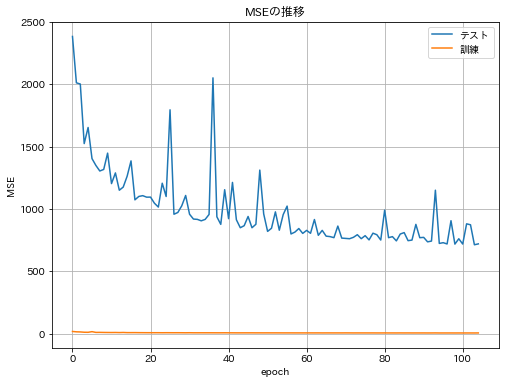

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(scores)-1), scores[1:], label="テスト")
ax.plot(range(len(scores)-1), losses[1:], label="訓練")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_title("MSEの推移")
ax.legend()
ax.grid()

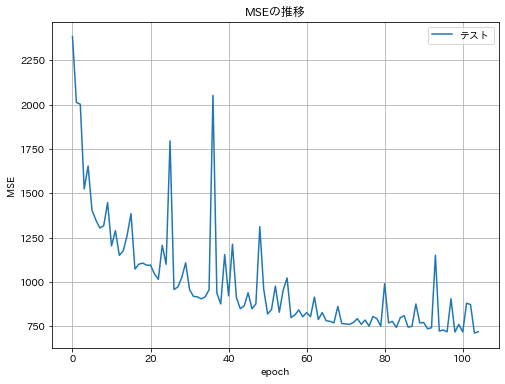

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(scores)-1), scores[1:], label="テスト")
# ax.plot(range(len(scores)-1), losses[1:], label="訓練")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_title("MSEの推移")
ax.legend()
ax.grid()

In [19]:
model = Model().to(device)

epochs = 1000
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
losses = []
scores = []
start_time = time.perf_counter()

for epoch in range(epochs):
    
    total_loss = 0.0
    if epoch == 0:
        print("開始時間: {}".format(time.perf_counter() - start_time))
    
    model.train()
    for num, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss_function = nn.MSELoss()
        outputs = outputs.reshape(-1)
        loss = loss_function(outputs, labels)
        # model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if not (loss.item() > 0):
            print(num, outputs, loss.item)
            break
    # with open(OUTPUTPATH + "loss/"+VERSION+".txt", mode="a") as f:
    #     f.write(str(round(total_loss,3)) + "\n")
            
    model.eval()
    actual_labels, pred_labels = np.empty(0), np.empty(0)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs * y_train_max
        labels, outputs = labels.reshape(-1), outputs.reshape(-1)
        actual_labels = np.concatenate([actual_labels, np.array(labels.cpu().numpy())])
        pred_labels = np.concatenate([pred_labels, np.array(outputs.cpu().detach().numpy())])
    score = mse(actual_labels, pred_labels)

    print("経過時間: {}, epoch数: {}, loss: {}, score: {}".format(
        round(time.perf_counter() - start_time, 3),
        epoch, 
        round(total_loss,3),
        round(score, 3)))
    
    if epoch >100 and total_loss > np.mean(losses[-10:]):
        scores.append(score)
        losses.append(total_loss)
        break
    losses.append(total_loss)
    scores.append(score)

開始時間: 0.000331047922372818
経過時間: 7.289, epoch数: 0, loss: 6245.823, score: 1003.1
経過時間: 14.727, epoch数: 1, loss: 6.653, score: 1755.155
経過時間: 22.187, epoch数: 2, loss: 6.584, score: 847.457
経過時間: 29.698, epoch数: 3, loss: 5.474, score: 791.293
経過時間: 37.003, epoch数: 4, loss: 5.551, score: 764.877
経過時間: 44.303, epoch数: 5, loss: 5.42, score: 796.726
経過時間: 51.625, epoch数: 6, loss: 5.283, score: 726.949
経過時間: 59.074, epoch数: 7, loss: 5.322, score: 734.308
経過時間: 66.499, epoch数: 8, loss: 4.966, score: 757.762
経過時間: 73.819, epoch数: 9, loss: 4.635, score: 854.586
経過時間: 81.074, epoch数: 10, loss: 4.593, score: 704.87
経過時間: 88.402, epoch数: 11, loss: 4.572, score: 778.638
経過時間: 95.609, epoch数: 12, loss: 4.509, score: 677.16
経過時間: 103.071, epoch数: 13, loss: 4.806, score: 674.926
経過時間: 110.275, epoch数: 14, loss: 4.493, score: 681.467
経過時間: 117.544, epoch数: 15, loss: 4.442, score: 673.64
経過時間: 124.796, epoch数: 16, loss: 4.417, score: 657.66
経過時間: 132.225, epoch数: 17, loss: 4.298, score: 662.105
経過時間: 139

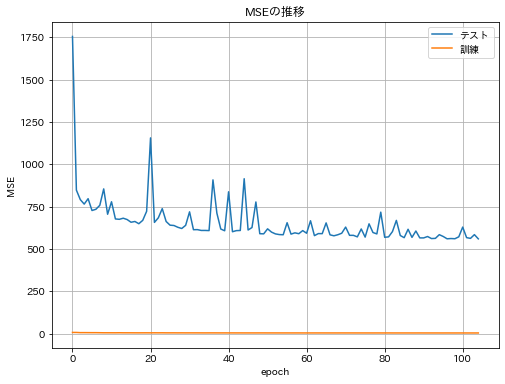

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(scores)-1), scores[1:], label="テスト")
ax.plot(range(len(scores)-1), losses[1:], label="訓練")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_title("MSEの推移")
ax.legend()
ax.grid()

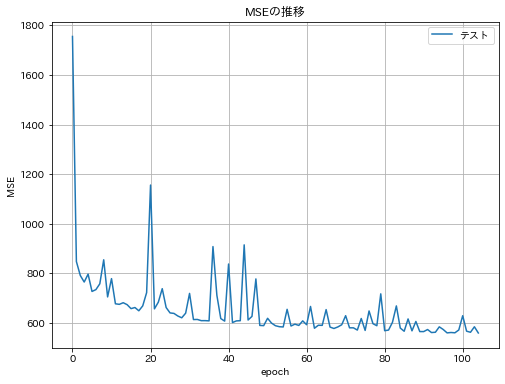

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(scores)-1), scores[1:], label="テスト")
# ax.plot(range(len(scores)-1), losses[1:], label="訓練")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_title("MSEの推移")
ax.legend()
ax.grid()